<a href="https://colab.research.google.com/github/massidi/TPLSTM_NLP/blob/main/tptransferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2018-valence-oc-en-dev-txt/2018-Valence-oc-En-dev.txt
/kaggle/input/2018-valence-oc-en-train-txt/2018-Valence-oc-En-train.txt
/kaggle/input/sentimental-analysis-tweets/tensorflow2/tp1/1/sentimentaltp1.h5


In [ ]:
!pip install tensorflow==2.15
!pip install --upgrade nltk


In [ ]:
import tensorflow as tf

from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional

import numpy as np
import pandas as pd


import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
import warnings

warnings.simplefilter("ignore")






from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

2024-04-15 11:59:23.909356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 11:59:23.909546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 11:59:24.081520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Read the text file into a DataFrame
train_tweets  = pd.read_csv("/kaggle/input/2018-valence-oc-en-train-txt/2018-Valence-oc-En-train.txt", sep='\t')

test_tweets  = pd.read_csv("/kaggle/input/2018-valence-oc-en-dev-txt/2018-Valence-oc-En-dev.txt", sep='\t')



In [ ]:
train_tweets.head(5)

print("------------------")

test_tweets.head(5)

------------------


,ID,Tweet,Affect Dimension,Intensity Class
0,2018-En-02354,So @Ryanair site crashes everytime I try to bo...,valence,-3: very negative emotional state can be inferred
1,2018-En-00124,Theme of week: Ask the Lord for strength &amp;...,valence,-2: moderately negative emotional state can be...
2,2018-En-02603,"@F1 Why announcing so late, it will be hard to...",valence,-3: very negative emotional state can be inferred
3,2018-En-00450,The greatest happiness is seeing someone you l...,valence,3: very positive emotional state can be inferred
4,2018-En-00502,omg so grateful to have an education but ive b...,valence,1: slightly positive emotional state can be in...


In [ ]:
print("shape of train_data:" ,train_tweets.shape)
print("count the nul value:" ,train_tweets.isnull().sum())

print("---------------\n")
print("shape of train_data:" ,test_tweets.shape)
print("count the nul value:" ,test_tweets.isnull().sum())

shape of train_data: (1181, 4)
count the nul value: ID                  0
Tweet               0
Affect Dimension    0
Intensity Class     0
dtype: int64
---------------

shape of train_data: (449, 4)
count the nul value: ID                  0
Tweet               0
Affect Dimension    0
Intensity Class     0
dtype: int64


In [ ]:
train_tweets['Intensity Class'] = pd.Categorical(train_tweets['Intensity Class'])

train_tweets['Label'] =train_tweets['Intensity Class'].cat.codes

In [ ]:
train_tweets.head(5)


,ID,Tweet,Affect Dimension,Intensity Class,Label
0,2017-En-30153,@liamch88 yeah! :) playing well,valence,0: neutral or mixed emotional state can be inf...,3
1,2017-En-40929,At least I don't have a guy trying to discoura...,valence,0: neutral or mixed emotional state can be inf...,3
2,2017-En-22012,UPLIFT: If you're still discouraged it means y...,valence,0: neutral or mixed emotional state can be inf...,3
3,2017-En-30837,"...at your age, the heyday in the blood is tam...",valence,0: neutral or mixed emotional state can be inf...,3
4,2017-En-30838,i was so embarrassed when she saw us i was lik...,valence,-2: moderately negative emotional state can be...,1


In [ ]:
test_tweets['Intensity Class'] = pd.Categorical(test_tweets['Intensity Class'])

test_tweets['Label'] =test_tweets['Intensity Class'].cat.codes

In [ ]:
test_tweets.head(5)


,ID,Tweet,Affect Dimension,Intensity Class,Label
0,2018-En-02354,So @Ryanair site crashes everytime I try to bo...,valence,-3: very negative emotional state can be inferred,2
1,2018-En-00124,Theme of week: Ask the Lord for strength &amp;...,valence,-2: moderately negative emotional state can be...,1
2,2018-En-02603,"@F1 Why announcing so late, it will be hard to...",valence,-3: very negative emotional state can be inferred,2
3,2018-En-00450,The greatest happiness is seeing someone you l...,valence,3: very positive emotional state can be inferred,6
4,2018-En-00502,omg so grateful to have an education but ive b...,valence,1: slightly positive emotional state can be in...,4


In [ ]:
print(train_tweets["Label"].value_counts())

print("___________")

print(test_tweets["Label"].value_counts())

Label
3    341
1    249
4    167
2    129
6    125
5     92
0     78
Name: count, dtype: int64
___________
Label
3    105
1     95
2     69
4     58
6     53
5     35
0     34
Name: count, dtype: int64


In [ ]:
# #For data visualization
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# %matplotlib inline

# pd.options.plotting.backend = "plotly"

<Axes: xlabel='Label'>

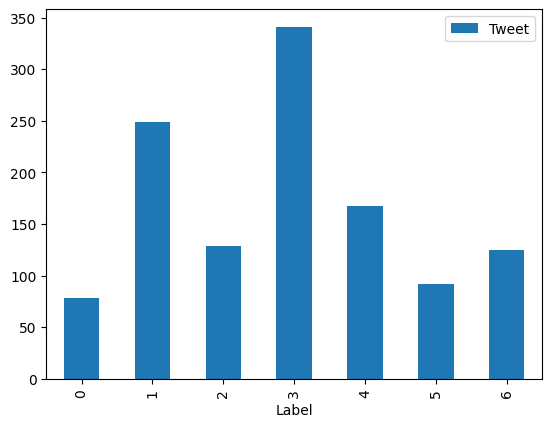

In [ ]:
data_train = train_tweets[['Tweet', 'Label']].copy()
data_train.groupby('Label').count().plot(kind='bar')

In [ ]:
# from sklearn.preprocessing import LabelEncoder



# label_encoder = LabelEncoder()

# train_messages= train_tweets.copy()

# # Map labels to numerical values
# train_messages['Intensity Class'] = label_encoder.fit_transform(train_messages["Intensity Class"])
# # test_messages['Intensity Class'] = label_encoder.fit_transform(test_messages['Intensity Class'])

# # print(train_messages)


# # train_label = train_messages.drop(['text'], axis=1)
# # test_label = test_messages.drop(['text'], axis=1)

# train_messages

<Axes: xlabel='Label'>

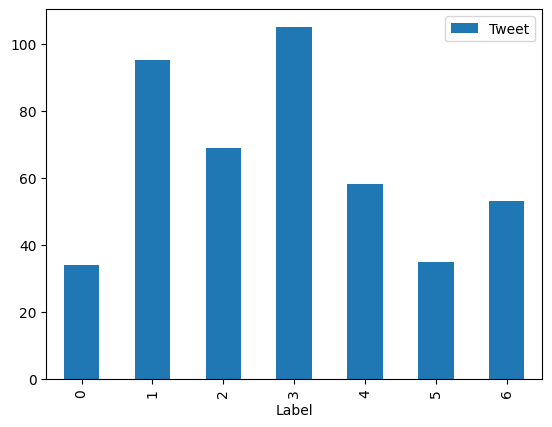

In [ ]:
data_test = test_tweets[['Tweet', 'Label']].copy()
data_test.groupby('Label').count().plot(kind='bar')

In [ ]:
m_train = train_tweets[['Tweet', 'Label']].copy()

m_test = test_tweets[['Tweet', 'Label']].copy()


In [ ]:
import re
import emoji
# from unidecode import unidecode

def clean_text(text):
    # Remove Unicode characters
    text = re.sub(r"\\u2019", "'", text)
    text = re.sub(r"\\u002c", ",", text)

    # Convert to lowercase and handle emojis
    text = emoji.demojize((text).lower())



    # Remove URLs
    text = re.sub(r"(http|https)?:\/\/[a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4}(/\S*)?", "", text)

    # Expand contractions
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r" can\'t", "cannot", text)
    text = re.sub(r"n\'t", "not", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r"\'d", "would", text)
    text = re.sub(r"\'11", "will", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'n", "", text)
    text = re.sub(r"\'m", "am", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Suppress repeated letters or vowels more than twice
    text = re.sub(r'([a-zA-Z])\1{2,}', r'\1', text)

    # Remove letters that are alone
    text = re.sub(r'\b\w\b', '', text)

    return text

In [ ]:
from keras.preprocessing.text import Tokenizer


# Download NLTK resources

# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')

# nltk.data.path.append('/kaggle/working/')


class TextPreprocessor:
    def __init__(self):
        # Initialize lemmatizer and stemmer
        self.lemm = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

        # Define stopwords including negation words
        self.stop_words = set(stopwords.words('english'))
        self.negation_words = {'not', 'no', 'never', 'nor'}
        self.stop_words -= self.negation_words

        # Initialize corpus
        self.corpus = []

    def normalized_text(self, data):
        """Preprocesses text data."""
        for i in range(len(data)):
#             review =  clean_text(data[i])
            review = re.sub('[^a-zA-Z]', ' ', data[i])
            review = review.lower()
            review = review.split()
            review = [self.lemm.lemmatize(word) for word in review if word not in self.stop_words]
            review = ' '.join(review)
            self.corpus.append(review)
        return self.corpus

    def preprocess_text(self, df, voc_size, sent_length):


        onehot_repr = [one_hot(words, voc_size) for words in df]
        embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
        return embedded_docs

    def vectorized_text(self,df,voc_size,sent_length):

        tok = Tokenizer(voc_size)
        tok.fit_on_texts(df)
        sequences = tok.texts_to_sequences(df)
        sequences_matrix = pad_sequences(sequences,maxlen=sent_length)
        return sequences_matrix

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

train_data_preprocessor = TextPreprocessor()

df2 = train_data_preprocessor.normalized_text(m_train['Tweet'])

print( pd.DataFrame({'text': df2}).shape)

(1181, 1)


In [ ]:
max_length = 0

# Iterate through each string in the list
for string in df2:

    words = string.split()

    for word in words:
        # Update maximum length if necessary
        max_length = max(max_length, len(word))


print("Maximum length of a word:", max_length)

Maximum length of a word: 29


In [ ]:

train_data_preprocessor = TextPreprocessor()

df3 = train_data_preprocessor.normalized_text(m_test['Tweet'])

print( pd.DataFrame({'text': df3}).shape)

(449, 1)


In [ ]:
voc_size=5000

embedded_docs_train =train_data_preprocessor.preprocess_text(df2,voc_size,396)

print(embedded_docs_train)

embedded_docs_test =train_data_preprocessor.preprocess_text(df3,voc_size,396)

print(embedded_docs_test)

[[   0    0    0 ... 3014 1490 3522]
 [   0    0    0 ... 1377 4325  251]
 [   0    0    0 ... 3978 1386 4376]
 ...
 [   0    0    0 ... 1756 3320 4888]
 [   0    0    0 ... 4371 4751 1413]
 [   0    0    0 ... 3437 2951 4465]]
[[   0    0    0 ... 1659 2658 4633]
 [   0    0    0 ... 2150  174 2597]
 [   0    0    0 ...   69  950 3750]
 ...
 [   0    0    0 ... 1042 2635  206]
 [   0    0    0 ... 4454 4454 4866]
 [   0    0    0 ... 3593 1310 4917]]


In [ ]:
pd.DataFrame({'Tweet': df3}).tail(10)

,Tweet
439,next time go lagos gate crash somebody owambe ...
440,popstufs coffee good view even better
441,tikitakaconnor eduardo without injury honestly...
442,ai revolation soon possible n fearless fearful...
443,post trnsmt blue
444,idk help someone smile come lip n n thatisall ...
445,think sleep favorite get dark maybe insomniac
446,amelia want sarah v grateful cbb
447,lack faith make people afraid meeting challeng...
448,james clapper scary disturbing thamendmentnow ...


In [ ]:
pd.DataFrame({'Tweet': df2}).tail(10)

,Tweet
1171,deltadomain sawdraze qurions dis dat nigga fum...
1172,see hovering block button today much glee
1173,serious need nap
1174,honestly awful people internet smh
1175,truly believe heart right satan rejoicing one ...
1176,dumteedum think ian knew pavel knew charlie be...
1177,lost wallet lol
1178,repentance trusting christ lowly painful also ...
1179,fordays chewing smile arcdental turlock
1180,anxious time leaving house horrid


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("semireddy/sentimental-analysis-tweets/tensorFlow2/tp1")

print("Path to model files:", path)

Attaching model 'semireddy/sentimental-analysis-tweets/tensorFlow2/tp1' to your Kaggle notebook...


Path to model files: /kaggle/input/sentimental-analysis-tweets/tensorflow2/tp1/1


In [ ]:
from keras.models import load_model

# Charger les poids du modèle pré-entraîné pour la tâche source (classification en 3 classes)
pretrained_model = load_model("/kaggle/input/sentimental-analysis-tweets/tensorflow2/tp1/1/sentimentaltp1.h5")

In [ ]:
dir(pretrained_model.layers)

In [ ]:
pretrained_layers=pretrained_model.layers
for layer in pretrained_layers:
    layer.trainable = False

In [ ]:
from keras.models import load_model
from keras.layers import Dense
from keras.models import Model

# Charger les poids du modèle pré-entraîné pour la tâche source (classification en 3 classes)
pretrained_layers=pretrained_model.layers[:-1]

for layer in pretrained_layers:
    layer.trainable = False
# Récupérer la sortie de la dernière couche du modèle pré-entraîné
pretrained_output = pretrained_layers[-1].output


x = Dense(100, activation='relu',name='new_layer3')(pretrained_output)  # Ajouter une couche dense
output_layer = Dense(7, activation='sigmoid', name='output_layer3')(x)  # Couche de sortie avec 7 classes

# Créer un nouveau modèle en spécifiant les entrées et les sorties
model7 = Model(inputs=pretrained_model.input, outputs=output_layer)

# Compiler le modèle
model7.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model7.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_input (InputLaye  [(None, 396)]             0         
 r)                                                              
                                                                 
 embedding (Embedding)       (None, 396, 20)           100000    
                                                                 
 bidirectional (Bidirection  (None, 300)               205200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               30150 

In [ ]:
print(model7.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_input (InputLaye  [(None, 396)]             0         
 r)                                                              
                                                                 
 embedding (Embedding)       (None, 396, 20)           100000    
                                                                 
 bidirectional (Bidirection  (None, 300)               205200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               30150 

In [ ]:
x_train=np.array(embedded_docs_train)
y_train=np.array(m_train['Label'])

x_train.shape,y_train.shape

((1181, 396), (1181,))

In [ ]:
x_validate =np.array(embedded_docs_test)
y_validate = np.array(m_test['Label'])

x_validate.shape, y_validate.shape

((449, 396), (449,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, random_state=5)


In [ ]:
X_test.shape,Y_test.shape

((296, 396), (296,))

In [ ]:
y_pred3 = model7.fit(x_train,y_train,validation_data=(x_validate,y_validate),epochs=25,batch_size=5)

Epoch 1/25
119/119 [==============================] - 18s 152ms/step - loss: 1.8808 - accuracy: 0.2599 - val_loss: 1.9005 - val_accuracy: 0.2339
Epoch 2/25
119/119 [==============================] - 18s 149ms/step - loss: 1.8545 - accuracy: 0.2820 - val_loss: 1.9145 - val_accuracy: 0.2339
Epoch 3/25
119/119 [==============================] - 19s 157ms/step - loss: 1.8647 - accuracy: 0.2820 - val_loss: 1.8966 - val_accuracy: 0.2183
Epoch 4/25
119/119 [==============================] - 19s 161ms/step - loss: 1.8632 - accuracy: 0.2684 - val_loss: 1.9086 - val_accuracy: 0.2316
Epoch 5/25
119/119 [==============================] - 18s 153ms/step - loss: 1.8732 - accuracy: 0.2777 - val_loss: 1.9163 - val_accuracy: 0.2227
Epoch 6/25
119/119 [==============================] - 18s 155ms/step - loss: 1.8561 - accuracy: 0.2752 - val_loss: 1.9004 - val_accuracy: 0.2361
Epoch 7/25
119/119 [==============================] - 18s 148ms/step - loss: 1.8708 - accuracy: 0.2794 - val_loss: 1.8919 - val_ac

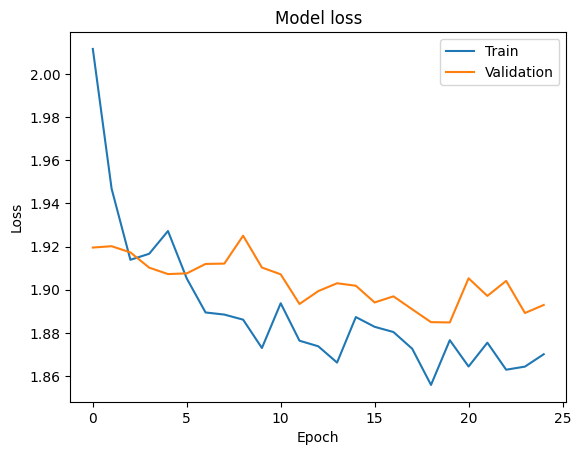

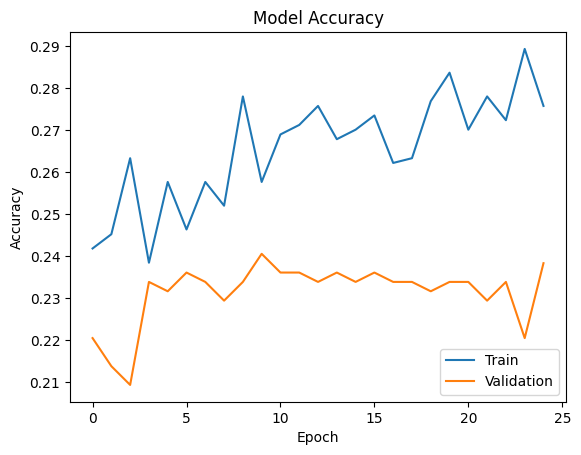

In [ ]:
import matplotlib.pyplot as plt


plt.plot(y_pred3.history['loss'])
plt.plot(y_pred3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Plot the accuracy of training and validation
plt.plot(y_pred3.history['accuracy'])
plt.plot(y_pred3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()